In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
unformatted = pd.read_excel('gold and silver.xlsx')

data = []
for date in unformatted['USD/Silver']:
    if date == pd.NaT:
        break

    gold_row = unformatted[unformatted['USD/Gold'] == date]
    # no corresponding gold price
    if gold_row.empty:
        continue

    silver_row = unformatted[unformatted['USD/Silver'] == date]
    
    data.append((date, gold_row['Unnamed: 5'].values[0], silver_row['Unnamed: 8'].values[0]))
    

spot_prices = pd.DataFrame(data, columns=['Date', 'Gold', 'Silver'])
spot_prices.set_index('Date', inplace=True)

In [3]:
gold_futures = pd.read_csv('GC00G.csv')
gold_futures['Date'] = pd.to_datetime(gold_futures['Date'])
gold_futures.set_index('Date', inplace=True)
gold_futures = gold_futures.loc[:, 'Close']

### Minimum Variance Cross-Hedge

In the case that an asset doesn't have its own futures contracts, a related asset can be used instead. The assets are assumed to have a roughly linear relationship:

$\Delta S = b + m \Delta F + \epsilon $

Where: $\Delta S$ : change in spot price \
$\Delta F$ : change in futures price

When short hedging the change in a positions value is:

$\Delta S - h\Delta F= b + (m-h) \Delta F + \epsilon $

Where h: hedge ratio

In order to minimise the variance of this position, is is clear that the hedge ratio h should be equal to the gradient m in the spot and futures relationship. 

In [4]:
# Pair gold future with silver spot for each timestamp
price_pairs = []
for date, gold_future_price in gold_futures.items():
    price_pairs.append((spot_prices.loc[date]['Silver'], gold_future_price))

change_pairs = []
prev_silver = price_pairs[0][0]
prev_future = price_pairs[0][1]
for (silver, future) in price_pairs[1:]:
    change_pairs.append((silver - prev_silver, future - prev_future))
    prev_silver = silver
    prev_future = future

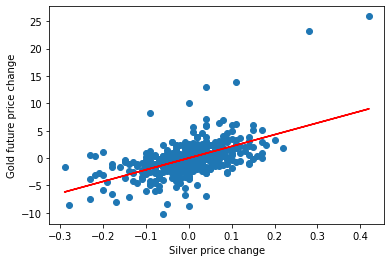

In [8]:
x, y = zip(*change_pairs)

gradient, offset = np.polyfit(x, y, 1)
regression = np.array(x) * gradient + offset
plt.scatter(x,y)
plt.plot(x, regression, color='red')
plt.xlabel('Silver price change')
plt.ylabel('Gold future price change')
plt.show()